# Workable Weather Window Analysis (WOWW Analysis)

This notebook aims to perform a workable weather window analysis of marine activities using [**waves**](https://polar.ncep.noaa.gov/waves/ensemble/download.shtml) and [**currents**](https://resources.marine.copernicus.eu/product-detail/GLOBAL_ANALYSIS_FORECAST_PHY_001_024/INFORMATION) forecasts. The analysis is based on the [DNV Offshore Standards for Marine Operations (DNV-OS-H101)](https://rules.dnv.com/docs/pdf/DNVPM/codes/docs/2011-10/Os-H101.pdf).

#### Notes
- By the time of the conception of this notebook, the datasets used were actual forecasts. Nonetheless, the principle is still aplicable for up-to-date forecast data from the mentioned sources.

## Importing libs

In [58]:
import pandas as pd
idx = pd.IndexSlice
import numpy as np
import xarray as xr
from wowwanalysis import WOWWAnalysis

# from metpy import calc

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

from glob import glob

import os
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data

A pre-processing step based on previous knowledge of the chosen forecasts dataset (WAVEWATCH III and MERCATOR) is also performed.

In [37]:
# General folder
data_folder_path = '/home/thiagocaminha/woww_analysis/data'
waves_folder_path = os.path.join(data_folder_path, 'waves_forecast')
currents_folder_path = os.path.join(data_folder_path, 'currents_forecast')
winds_folder_path = os.path.join(data_folder_path, 'winds_forecast')

# WAVES
# loading
os.chdir(waves_folder_path) # chdir
# waves = xr.open_dataset('ww3_global_cef2_9b31_0848.nc') # load
waves = xr.open_dataset('ww3_global_51f2_2d2c_15bb.nc') # test1

# pre-processing
waves = waves.rename({'longitude':'lon','latitude':'lat','Thgt':'swvht'})
waves['lon'] = waves['lon'] - 360
waves = waves.squeeze(drop=True)

# CURRENTS
# loading
os.chdir(currents_folder_path) # chdir
# curr = xr.open_dataset('global-analysis-forecast-phy-001-024-hourly-t-u-v-ssh_1645281307400.nc')
curr = xr.open_dataset('global-analysis-forecast-phy-001-024-hourly-t-u-v-ssh_1662861968722.nc') # test1

# pre-processing
curr = curr.rename({'longitude':'lon','latitude':'lat'}) # standardizing names
curr = curr.squeeze(drop=True) # squeezing dimentions to surface waters
# curr['uo'].values = curr['uo'].values*1.94384
# curr['uo'] = curr['uo'].assign_attrs(units='kt')
# curr['vo'].values = curr['vo'].values*1.94384
# curr['vo'] = curr['vo'].assign_attrs(units='kt')
curr['cvel'] = np.sqrt(curr['uo']**2 + curr['vo']**2)
curr['cvel'] = curr['cvel'].assign_attrs(units='kt')

# WIND
winds_data_path = os.path.join(winds_folder_path, 'ncep_global_a04e_6daa_7393.nc')
winds = xr.open_dataset(winds_data_path) # test1
winds = winds.rename({'longitude':'lon','latitude':'lat'})
winds['lon'] = winds['lon'] - 360
winds = winds.squeeze(drop=True)



## Data Selection

Let's say we want to perform the analysis at lon/lat -36.0/0., which is located in the equatorial Atlantic Ocean.

In [39]:
# Selection
lon_par = -36.
lat_par = 0.
waves = waves.sel(lon=lon_par,lat=lat_par,method='nearest')
# curr = curr.sel(lon=lon_par,lat=lat_par,method='nearest')
winds = winds.sel(lon=lon_par,lat=lat_par,method='nearest')

## Data Merge

For the best functioning of the analysis function, the aimed parameters must be merged along the time dimension. 

In [40]:
# Check time range of datasets
def get_date_range(data):
    start = data['time'].min().values.astype('str')[:19]
    end = data['time'].max().values.astype('str')[:19]
    rang = f'{start} - {end}'
    return rang
def get_time_step(data):
    start = data['time'][0].values
    end = data['time'][1].values
    time_step = pd.to_timedelta(end - start)
    return time_step

print(f'waves Time range: {get_date_range(waves)}, time step = ({get_time_step(waves)})')
print(f'curr Time range: {get_date_range(curr)}, time step = ({get_time_step(curr)})')
print(f'winds Time range: {get_date_range(winds)}, time step = ({get_time_step(winds)})')

waves Time range: 2022-09-10T18:00:00 - 2022-09-16T18:00:00, time step = (0 days 01:00:00)
curr Time range: 2022-09-10T17:30:00 - 2022-09-16T19:30:00, time step = (0 days 01:00:00)
winds Time range: 2022-09-10T18:00:00 - 2022-09-17T18:00:00, time step = (0 days 03:00:00)


As we can notice, the datasets have different time references. To allow a propper merge along the time, a quick processing is needed.

### Time processing

In [41]:
# Currents data interpolation
curr_res = curr.resample(time='30T').interpolate()
time_sel = curr_res['time'][1::2]
curr_res = curr_res.sel(time=time_sel)

# Winds data interpolation
winds_res = winds.resample(time='1H').interpolate()

In [43]:
print(f'waves Time range: {get_date_range(waves)}, time step = ({get_time_step(waves)})')
print(f'curr Time range: {get_date_range(curr_res)}, time step = ({get_time_step(curr_res)})')
print(f'winds Time range: {get_date_range(winds_res)}, time step = ({get_time_step(winds_res)})')

waves Time range: 2022-09-10T18:00:00 - 2022-09-16T18:00:00, time step = (0 days 01:00:00)
curr Time range: 2022-09-10T18:00:00 - 2022-09-16T19:00:00, time step = (0 days 01:00:00)
winds Time range: 2022-09-10T18:00:00 - 2022-09-17T18:00:00, time step = (0 days 01:00:00)


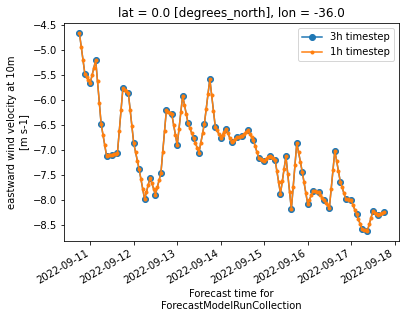

In [31]:
winds['ugrd10m'].plot(marker='.',markersize=12,label='3h timestep')
winds_res['ugrd10m'].plot(marker='.',label='1h timestep')
plt.legend()

### Wind parameters calculation

In [50]:
winds_res['wvel'] = np.sqrt(winds_res['ugrd10m']**2 + winds_res['vgrd10m']**2)

In [59]:
# winds_res['wvel'] =

#### Merging datasets

In [60]:
# waves + currents data
data_wc = waves.merge(curr_res)
data_wc = data_wc[['swvht','Tper','cvel']].dropna(dim='time')

In [62]:
data_wcw = data_wc.merge(winds_res)[['swvht','Tper','cvel','wvel']]

In [63]:
data_wcw

<xarray.Dataset>
Dimensions:  (time: 169)
Coordinates:
  * time     (time) datetime64[ns] 2022-09-10T18:00:00 ... 2022-09-17T18:00:00
    lat      float64 0.0
    lon      float64 -36.0
Data variables:
    swvht    (time) float32 1.7 1.71 1.71 1.72 1.73 1.74 ... nan nan nan nan nan
    Tper     (time) float32 8.475 8.475 8.403 8.403 8.403 ... nan nan nan nan
    cvel     (time) float64 0.9694 0.9663 0.9593 0.9527 ... nan nan nan nan
    wvel     (time) float64 7.524 7.59 7.667 7.756 ... 8.639 8.533 8.44 8.359
Attributes: (12/68)
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    acknowledgement:               The Pacific Islands Ocean Observing System...
    cdm_data_type:                 Grid
    comment:                       Model runs produced by Kwok Fai Cheung (ch...
    Conventions:                   CF-1.6, ACDD-1.3
    creator_email:                 cheung@hawaii.edu
    ...                            ...
    testOutOfDate:                 now+105hours
    time_coverage_end:             2022-09-16T18:00:00Z
    time_coverage_resolution:      PT1H
    time_coverage_start:           2022-09-10T18:00:00Z
    title:                         WaveWatch III (WW3) Global Wave Model
    Westernmost_Easting:           310.0

# Performing the WOWW Analysis

In [10]:
data_wc

<xarray.Dataset>
Dimensions:  (time: 138)
Coordinates:
  * time     (time) datetime64[ns] 2022-02-18T01:00:00 ... 2022-02-23T18:00:00
    lat      float32 0.0
    lon      float32 -36.0
Data variables:
    swvht    (time) float32 1.55 1.55 1.54 1.54 1.53 ... 1.9 1.9 1.89 1.88 1.88
    Tper     (time) float32 8.621 8.547 8.547 8.547 ... 11.49 11.49 11.49 11.49
    cvel     (time) float64 0.1696 0.1623 0.1539 0.1442 ... 0.4117 0.4331 0.4504
Attributes: (12/68)
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    acknowledgement:               The Pacific Islands Ocean Observing System...
    cdm_data_type:                 Grid
    comment:                       Model runs produced by Kwok Fai Cheung (ch...
    Conventions:                   CF-1.6, ACDD-1.3
    creator_email:                 cheung@hawaii.edu
    ...                            ...
    testOutOfDate:                 now+105hours
    time_coverage_end:             2022-02-23T18:00:00Z
    time_coverage_resolution:      PT1H
    time_coverage_start:           2022-02-18T00:00:00Z
    title:                         WaveWatch III (WW3) Global Wave Model
    Westernmost_Easting:           310.0

In [11]:
op_start=pd.to_datetime('2022-02-23T00:00:00')
wf_issuance=pd.to_datetime('2022-02-22T18:00:00')

wa = WOWWAnalysis(data_wc,
                    op_start=op_start,
                    tpop=4,
                    cont_factor=0.5,
                    toggle_op=True,
                    toggle_op_plot=True,
                    wf_issuance=wf_issuance,
                    swvht_limit=2.,
                    tper_limit=10,
                    cvel_limit=0.6,
                    figsize=(10,3))

In [1]:
wa.wowws

NameError: name 'wa' is not defined

In [13]:
wa.time_reference

Timedelta('0 days 12:00:00')

In [14]:
wa.wowws_allowed

,WINDOW 3
START,2022-02-22 18:00:00
END,2022-02-23 18:00:00
DURATION,1 days 00:00:00


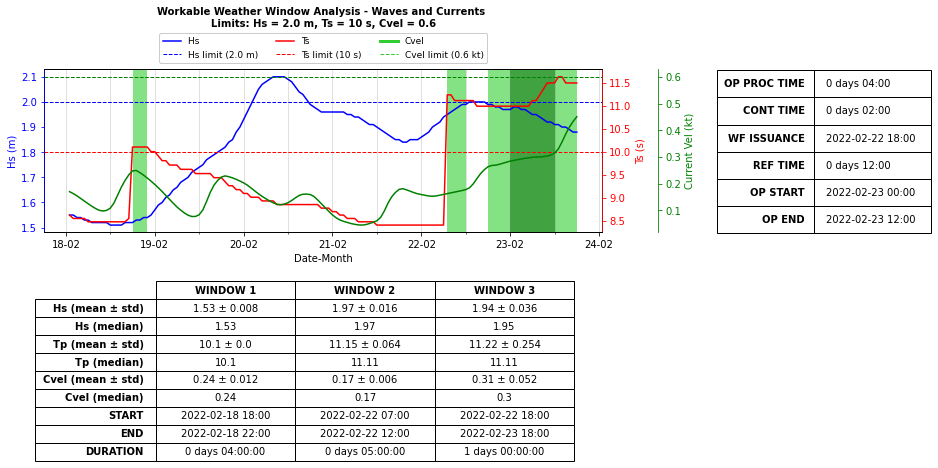

In [15]:
wa.woww_analysis()